In [1]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import h5py

# Prepare Data

In [11]:
(x_img_train, y_label_train), (x_img_test, y_label_test) = cifar10.load_data()

# resize images to (64,64)

x_img_train = np.array([cv2.resize(img, (64, 64)) for img in x_img_train])
x_img_test = np.array([cv2.resize(img, (64, 64)) for img in x_img_test])

# normalizing images

x_img_train = x_img_train / 255.0
x_img_test = x_img_test / 255.0

print('x_img_train:', x_img_train.shape)
print('y_label_train:', y_label_train.shape)
print('x_img_test:', x_img_test.shape)
print('y_label_test:', y_label_test.shape)

cat = 3

# changing labels to y=1 for 'cat' and y=0 for 'non-cat'

y_label_train = (y_label_train.flatten()==cat).astype(int).reshape(-1,1)
y_label_test = (y_label_test.flatten()==cat).astype(int).reshape(-1,1)

with h5py.File('data.h5','w') as hf:
    dset_xtrain = hf.create_dataset('x_train', data=x_img_train, shape=(x_img_train.shape[0], x_img_train.shape[1], x_img_train.shape[2], 3), compression='gzip', chunks=True)
    dset_ytrain = hf.create_dataset('y_train', data=y_label_train, shape=(y_label_train.shape[0], 1), compression='gzip', chunks=True)
    dset_xtest = hf.create_dataset('x_test', data=x_img_test, shape=(x_img_test.shape[0], x_img_test.shape[1], x_img_test.shape[2], 3), compression='gzip', chunks=True)
    dset_ytest = hf.create_dataset('y_test', data=y_label_test, shape=(y_label_test.shape[0], 1), compression='gzip', chunks=True)


x_img_train: (50000, 64, 64, 3)
y_label_train: (50000, 1)
x_img_test: (10000, 64, 64, 3)
y_label_test: (10000, 1)


# Load Data

In [2]:
def load_data(file):
    with h5py.File(file, 'r') as hf:
        x_train = np.array(hf['x_train'])
        y_train = np.array(hf['y_train'])
        x_test = np.array(hf['x_test'])
        y_test = np.array(hf['y_test'])
    return x_train, y_train, x_test, y_test


train_x_orig, train_y, test_x_orig, test_y = load_data('data.h5')

m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 50000
Number of testing examples: 10000
Each image is of size: (64, 64, 3)
train_x_orig shape: (50000, 64, 64, 3)
train_y shape: (50000, 1)
test_x_orig shape: (10000, 64, 64, 3)
test_y shape: (10000, 1)


In [3]:
train_x = train_x_orig.reshape(train_x_orig.shape[0], -1).T 
test_x = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_y = train_y.reshape(1, -1)  # Shape: (1, m)
test_y = test_y.reshape(1, -1)  # Shape: (1, m)

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (12288, 50000)
test_x's shape: (12288, 10000)
train_y's shape: (1, 50000)
test_y's shape: (1, 10000)


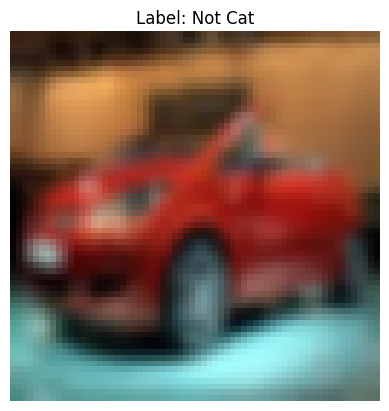

In [26]:
image = train_x_orig[45]
label = train_y[0][45]

#image = cv2.resize(image,(32,32))

plt.imshow(image)
plt.title(f"Label: {'Cat' if label == 1 else 'Not Cat'}")
plt.axis('off')  # Hide axes
plt.show()

# Helping Functions

In [4]:
def sigmoid(Z):
    """
    Returns:
    A -- output of sigmoid function, same shape as Z
    cache -- stores Z, to be used in backward propagation
    """
    A = 1 / (1 + np.exp(-Z))  # Sigmoid activation
    cache = Z  # Store Z for backpropagation
    return A, cache


def relu(Z):
    """
    Returns:
    A -- output of ReLU function, same shape as Z
    cache -- stores Z, to be used in backward propagation
    """
    A = np.maximum(0, Z)  # ReLU activation
    cache = Z  # Store Z for backpropagation
    return A, cache

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """

    epsilon = 1e-10  # Small value to prevent log(0)
    AL = np.clip(AL, epsilon, 1 - epsilon)  # Clip AL to prevent log(0) 
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost


def sigmoid_backward(dA, activation_cache):
    """
    Implements the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- Gradient of the cost with respect to activation A.
    activation_cache -- 'Z' stored during the forward propagation (used to compute dZ).

    Returns:
    dZ -- Gradient of the cost with respect to Z.
    """
    Z = activation_cache
    A = 1 / (1 + np.exp(-Z))  # Sigmoid activation
    dZ = dA * A * (1 - A)  # Derivative of sigmoid
    return dZ


def relu_backward(dA, activation_cache):
    """
    Implements the backward propagation for a single RELU unit.

    Arguments:
    dA -- Gradient of the cost with respect to activation A.
    activation_cache -- 'Z' stored during the forward propagation (used to compute dZ).

    Returns:
    dZ -- Gradient of the cost with respect to Z.
    """
    Z = activation_cache
    dZ = np.array(dA, copy=True)  # Copy dA to avoid modifying it

    # Compute the gradient where Z > 0
    dZ[Z <= 0] = 0  # Set dZ to 0 where Z is negative or zero
    return dZ


In [5]:
def initialize_parameters_shallow(n_x, n_y):
    np.random.seed(1)

    W1 = np.random.randn(n_y, n_x) * 0.01  # Use n_y and n_x here as there's only one layer
    b1 = np.zeros((n_y, 1))  # Bias is for the output layer
    parameters = {"W1": W1, "b1": b1}

    return parameters


def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    


def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    temp = np.dot(W, A)

    #print('temp: ', temp.shape)
    b = b[:, 0:1]

    #print('b: ', b.shape)
    Z = temp + b

    #print('W: ', W.shape)
    #print('A: ', A.shape)
    

    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache



def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, cache[0].T) / m
    db = np.squeeze(np.sum(dZ, axis=1, keepdims=True)) / m

    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    #assert (isinstance(db, float))
    
    return dA_prev, dW, db



def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db



def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters


# Shallow Network

In [6]:
def shallow_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a neural network with no hidden layer: LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1 and b1
    """
    
    np.random.seed(1)
    grads = {}
    costs = []  
    m = X.shape[1]  
    (n_x, n_y) = layers_dims
    
    # Initialize parameters dictionary
    parameters = initialize_parameters_shallow(n_x, n_y)  
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation
        Z, cache1 = linear_forward(X, W1, b1)
        A2, cache2 = sigmoid(Z) 
    
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Backward propagation
        epsilon = 1e-10  # Small value to prevent division by zero
        A2 = np.clip(A2, epsilon, 1 - epsilon)
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        # Backward propagation
        dZ = sigmoid_backward(dA2, cache2)
        dA0, dW1, db1 = linear_backward(dZ, cache1)
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        
        # Update parameters
        parameters["W1"] = parameters["W1"] - learning_rate * grads["dW1"]
        parameters["b1"] = parameters["b1"] - learning_rate * grads["db1"]

        # Retrieve W1, b1 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


(12288, 500)
(1, 500)
(12288, 100)
(1, 100)
Cost after iteration 0: 1.0841133988455818
Cost after iteration 100: 0.28340949242833535
Cost after iteration 200: 0.2614480059809934
Cost after iteration 300: 0.24646756012390075
Cost after iteration 400: 0.23471344989720666
Cost after iteration 500: 0.22488080057131135
Cost after iteration 600: 0.21637286854603782
Cost after iteration 700: 0.20885517056004202
Cost after iteration 800: 0.2021130294421568
Cost after iteration 900: 0.19599672256652337
Cost after iteration 1000: 0.1903964095438392
Cost after iteration 1100: 0.18522882464615242
Cost after iteration 1200: 0.1804293572984488
Cost after iteration 1300: 0.17594695273916802
Cost after iteration 1400: 0.17174065251233317
Cost after iteration 1500: 0.16777716231090795
Cost after iteration 1600: 0.16402909710890456
Cost after iteration 1700: 0.16047368907373943
Cost after iteration 1800: 0.15709182027329258
Cost after iteration 1900: 0.15386728826284968
Cost after iteration 2000: 0.1507

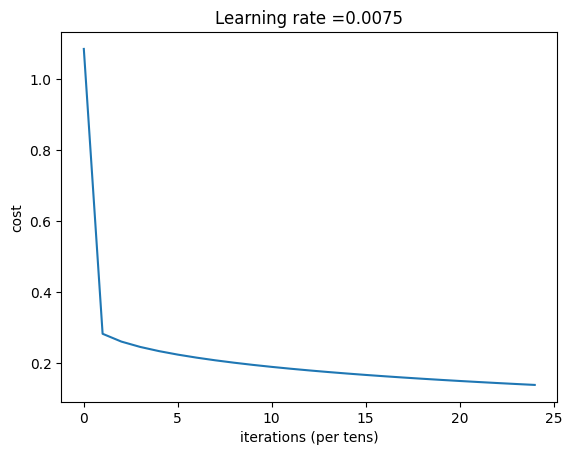

In [7]:
# Use only the first 500 examples for training and 100 for testing
train_x_small = train_x[:, :500]
train_y_small = train_y[:,:500]
test_x_small = test_x[:, :100]
test_y_small = test_y[:, :100]

print(train_x_small.shape) 
print(train_y_small.shape) 
print(test_x_small.shape)  
print(test_y_small.shape) 

n_x = 12288     # num_px * num_px * 3
n_y = 1
layers_dims = (n_x, n_y)

# Train on smaller dataset
parameters1 = shallow_model(train_x_small, train_y_small, layers_dims,learning_rate=0.0075, num_iterations=2500, print_cost=True)

# 2-Layer Network

In [8]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """

    np.random.seed(1)
    grads = {}
    costs = []                             
    m = X.shape[1]                          
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
        # Forward propagation
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
    
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        # Backward propagation 
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        ### END CODE HERE ###
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters



(12288, 500)
(1, 500)
(12288, 100)
(1, 100)
Cost after iteration 0: 0.6911565450287916
Cost after iteration 100: 0.3215144148865729
Cost after iteration 200: 0.3173142463558155
Cost after iteration 300: 0.312838321896215
Cost after iteration 400: 0.30770510691170355
Cost after iteration 500: 0.3017015252200955
Cost after iteration 600: 0.29478383584053414
Cost after iteration 700: 0.28749759569911204
Cost after iteration 800: 0.27972228562368845
Cost after iteration 900: 0.2717380246823942
Cost after iteration 1000: 0.2636914298522969
Cost after iteration 1100: 0.2556583497854438
Cost after iteration 1200: 0.24749936339151812
Cost after iteration 1300: 0.23923650651195472
Cost after iteration 1400: 0.23089195365434564
Cost after iteration 1500: 0.22251630502008043
Cost after iteration 1600: 0.2141357443127637
Cost after iteration 1700: 0.20579908470373703
Cost after iteration 1800: 0.1975442314898185
Cost after iteration 1900: 0.18940771023504582
Cost after iteration 2000: 0.1814343868

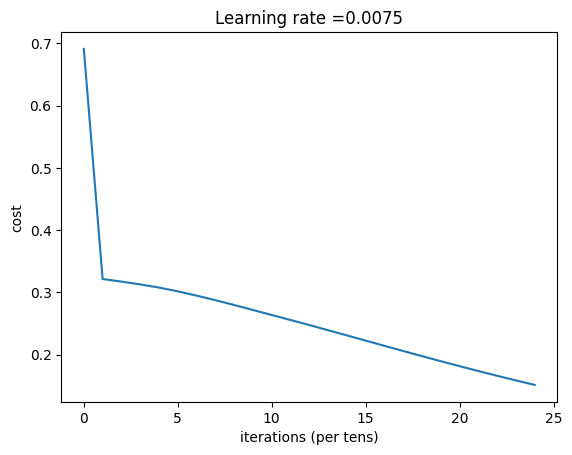

In [9]:
# Use only the first 500 examples for training and 100 for testing
train_x_small = train_x[:, :500]
train_y_small = train_y[:,:500]
test_x_small = test_x[:, :100]
test_y_small = test_y[:, :100]

print(train_x_small.shape) 
print(train_y_small.shape) 
print(test_x_small.shape)  
print(test_y_small.shape) 

n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

# Train on smaller dataset
parameters2 = two_layer_model(train_x_small, train_y_small, layers_dims, num_iterations=2500, print_cost=True)


# L-Layers Network

In [10]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters



def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                 

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
        
    
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches



def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(sigmoid_backward(dAL, 
                                                                                                        current_cache[1]), 
                                                                                       current_cache[0])
    
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
        grads["dA" + str(l + 2)], current_cache, activation='relu'
                                                        )
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp


    return grads

In [11]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                       
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        # Forward propagation
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

(12288, 500)
(1, 500)
(12288, 100)
(1, 100)
Cost after iteration 0: 0.693149
Cost after iteration 100: 0.589921
Cost after iteration 200: 0.518464
Cost after iteration 300: 0.468224
Cost after iteration 400: 0.432216
Cost after iteration 500: 0.405893
Cost after iteration 600: 0.386288
Cost after iteration 700: 0.371437
Cost after iteration 800: 0.360015
Cost after iteration 900: 0.351111
Cost after iteration 1000: 0.344088
Cost after iteration 1100: 0.338491
Cost after iteration 1200: 0.333988
Cost after iteration 1300: 0.330335
Cost after iteration 1400: 0.327352
Cost after iteration 1500: 0.324898
Cost after iteration 1600: 0.322869
Cost after iteration 1700: 0.321182
Cost after iteration 1800: 0.319773
Cost after iteration 1900: 0.318591
Cost after iteration 2000: 0.317596
Cost after iteration 2100: 0.316756
Cost after iteration 2200: 0.316043
Cost after iteration 2300: 0.315438
Cost after iteration 2400: 0.314922


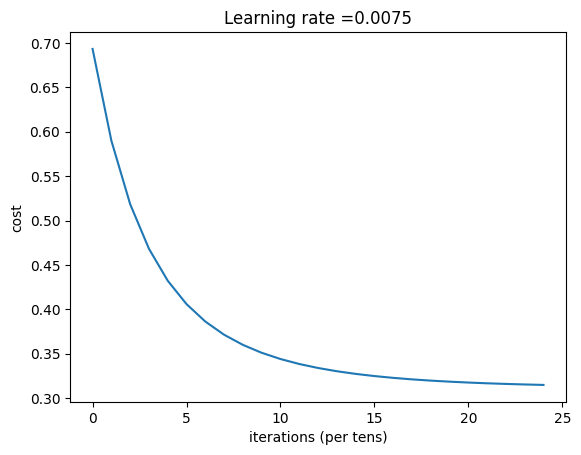

In [12]:

# Use only the first 500 examples for training and 100 for testing
train_x_small = train_x[:, :500]
train_y_small = train_y[:,:500]
test_x_small = test_x[:, :100]
test_y_small = test_y[:, :100]

print(train_x_small.shape) 
print(train_y_small.shape) 
print(test_x_small.shape)  
print(test_y_small.shape) 


layers_dims = [12288, 20, 7, 5, 1]

parameters3 = L_layer_model(train_x_small, train_y_small, layers_dims, num_iterations=2500, print_cost=True)


# Test Accuracy

In [13]:
# Predict Functions to test accuracy of all models


def predict_shallow(X, parameters):

    # Forward propagation
    Z, cache1 = linear_forward(X, parameters["W1"], parameters["b1"])
    A2, cache2 = sigmoid(Z)

    # Make predictions (if A2 >= 0.5, predict 1, else predict 0)
    predictions = (A2 > 0.5)

    return predictions



def predict_two_layer(X, parameters):

    # Forward propagation
    A1, cache1 = linear_activation_forward(X, parameters["W1"], parameters["b1"], 'relu')
    A2, cache2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], 'sigmoid')

    # Make predictions (if A2 >= 0.5, predict 1, else predict 0)
    predictions = (A2 > 0.5)

    return predictions


def predict_L_layer(X, parameters):

    # Forward propagation
    AL, _ = L_model_forward(X, parameters)
 
    # Convert probabilities to binary predictions
    predictions = (AL > 0.5)
    
    return predictions


# Test the model
predictions1 = predict_shallow(test_x_small, parameters1)
predictions2 = predict_two_layer(test_x_small, parameters2)
predictions3 = predict_L_layer(test_x_small, parameters3)

# Calculate accuracy
accuracy1 = np.mean(predictions1 == test_y_small)
accuracy2 = np.mean(predictions2 == test_y_small)
accuracy3 = np.mean(predictions3 == test_y_small)
print(f"Accuracy of Shallow network on the test set: {accuracy1 * 100:.2f}%")
print(f"Accuracy of Two layers network on the test set: {accuracy2 * 100:.2f}%")
print(f"Accuracy of 5 layers network on the test set: {accuracy3 * 100:.2f}%")




Accuracy of Shallow network on the test set: 89.00%
Accuracy of Two layers network on the test set: 89.00%
Accuracy of 5 layers network on the test set: 90.00%
